# Handling grid metrics in CMIP6

Almost any analysis with model data involves [grid metrics](https://xgcm.readthedocs.io/en/latest/grid_metrics.html) like cell area, cell volume etc. 
These are essential to compute e.g. global averages since the cells in ocean models are usually not of equal size.

Within the CMIP6 archive grid metrics are stored as seperate variables like `areacello` (horizontal grid area) or `thkcello`(vertical cell thickness), and it can be rather cumbersome to match these. 
`cmip6_preprocessing` has some functions to make this easy, which also offer some options to use metrics from e.g. another experiment in case these are not available (more on that below).


Lets start by loading a bunch of ocean temperature output into a dictionary of datasets

## Todo

- clarify why the version is not in the metadata anymore?

In [1]:
# import dask
# dask.config.set(**{'array.slicing.split_large_chunks': True})
# from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
import numpy as np
from cmip6_preprocessing.utils import google_cmip_col
from cmip6_preprocessing.preprocessing import combined_preprocessing

col = google_cmip_col()
experiment_id='historical'
source_id = 'MPI-ESM1-2-LR'
kwargs = {'zarr_kwargs':{'consolidated':True, 'use_cftime':True}, 'aggregate':False, 'preprocess':combined_preprocessing}

cat_data = col.search(source_id=source_id, experiment_id=experiment_id, variable_id='thetao')
ddict = cat_data.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/Users/juliusbusecke/miniconda/envs/cmip6_preprocessing_docs/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/juliusbusecke/miniconda/envs/cmip6_preprocessing_docs/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):


/Users/juliusbusecke/miniconda/envs/cmip6_preprocessing_docs/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/juliusbusecke/miniconda/envs/cmip6_preprocessing_docs/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):


> Note the `aggregate=False` option, which prevents the concatenation of model members in this case.
I have found that in many cases this concatenation can lead to dask performance problems and I currently 
do not recommend it in my workflow. 

Now lets repeat the step, but switch the 

In [6]:
cat_metric = col.search(source_id=source_id, experiment_id=experiment_id, variable_id='areacello')
ddict_metrics = cat_metric.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [9]:
from cmip6_preprocessing.postprocessing import match_metrics
ddict_matched = match_metrics(ddict, ddict_metrics, ['areacello'])

Processed 10 datasets.
Exact matches:{'areacello': 0}
Other matches:{'areacello': 10}
No match found:{'areacello': 0}


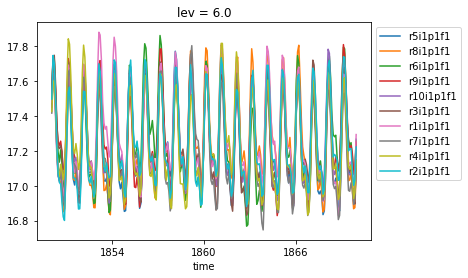

In [15]:
fig, ax = plt.subplots()
for i, ds in enumerate(ddict_matched.values()):
    # calculate the weighted average over the surface level temperatures
    area = ds.areacello.fillna(0)
    da = ds.thetao.isel(lev=0, time=slice(0,240)).weighted(area).mean(['x','y']).squeeze().load()
    l = da.plot(ax=ax, color=f'C{i}', label=ds.attrs['variant_label'])
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [16]:
cat_metric = col.search(source_id=source_id, variable_id=['areacello', 'thkcello'], experiment_id='historical')
ddict_metrics = cat_metric.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/Users/juliusbusecke/miniconda/envs/cmip6_preprocessing_docs/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/juliusbusecke/miniconda/envs/cmip6_preprocessing_docs/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):


/Users/juliusbusecke/miniconda/envs/cmip6_preprocessing_docs/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/juliusbusecke/miniconda/envs/cmip6_preprocessing_docs/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):


In [17]:
ddict_matched_again = match_metrics(ddict, ddict_metrics, ['areacello', 'thkcello'])

Processed 10 datasets.
Exact matches:{'areacello': 0, 'thkcello': 10}
Other matches:{'areacello': 10, 'thkcello': 0}
No match found:{'areacello': 0, 'thkcello': 0}


In [18]:
ddict_matched_again['CMIP.MPI-M.MPI-ESM1-2-LR.historical.r2i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r2i1p1f1/Omon/thetao/gn/v20190710/.nan.20190710']

<xarray.Dataset>
Dimensions:        (bnds: 2, lev: 40, time: 1980, vertex: 4, x: 256, y: 220)
Coordinates:
  * x              (x) float64 1.128 2.285 3.446 4.609 ... 357.7 358.8 360.0
  * y              (y) float64 -72.02 -71.72 -71.41 -71.1 ... 89.33 89.67 89.73
    lat            (y, x) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
  * lev            (lev) float64 6.0 17.0 27.0 ... 4.67e+03 5.17e+03 5.72e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(40, 2), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
  * time           (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(220, 256, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(220, 256, 4), meta=np.ndarray>
  * bnds           (bnds) int64 0 1
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 220, 256), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 220, 256), meta=np.ndarray>
    areacello      (y, x) float32 dask.array<chunksize=(220, 256), meta=np.ndarray>
    thkcello       (time, lev, y, x) float32 dask.array<chunksize=(66, 40, 220, 256), meta=np.ndarray>
Data variables:
    thetao         (time, lev, y, x) float32 dask.array<chunksize=(13, 40, 220, 256), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   18262.0
    cmor_version:            3.5.0
    contact:                 cmip6-mpi-esm@dkrz.de
    creation_date:           2019-09-02T13:08:50Z
    data_specs_version:      01.00.30
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacello volcello
    forcing_index:           1
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.MPI-M.MPI-E...
    grid:                    gn
    grid_label:              gn
    history:                 2019-09-02T13:08:50Z ; CMOR rewrote data to be c...
    initialization_index:    1
    institution:             Max Planck Institute for Meteorology, Hamburg 20...
    institution_id:          MPI-M
    license:                 CMIP6 model data produced by MPI-M is licensed u...
    mip_era:                 CMIP6
    nominal_resolution:      250 km
    parent_activity_id:      CMIP
    parent_experiment_id:    piControl
    parent_mip_era:          CMIP6
    parent_source_id:        MPI-ESM1-2-LR
    parent_time_units:       days since 1850-1-1 00:00:00
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    project_id:              CMIP6
    realization_index:       2
    realm:                   ocean
    references:              MPI-ESM: Mauritsen, T. et al. (2019), Developmen...
    source:                  MPI-ESM1.2-LR (2017): \naerosol: none, prescribe...
    source_id:               MPI-ESM1-2-LR
    source_type:             AOGCM
    status:                  2020-07-12;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Omon
    table_info:              Creation Date:(09 May 2019) MD5:e6ef8ececc8f3386...
    title:                   MPI-ESM1-2-LR output prepared for CMIP6
    tracking_id:             hdl:21.14100/9a791e46-3b24-49f0-a628-66ef71241d7...
    variable_id:             thetao
    variant_label:           r2i1p1f1
    netcdf_tracking_ids:     hdl:21.14100/9a791e46-3b24-49f0-a628-66ef71241d7...
    version_id:              v20190710
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.MPI-M.MPI-ESM1-2-LR.histo

In [ ]:
fig, ax = plt.subplots()
for i, ds in enumerate(ddict_matched_again.values()):
    # calculate the volume weighted mean ocean temperature
    vol = (ds.areacello * ds.thkcello)
    da = ds.thetao.isel(time=slice(-240, None)).weighted(vol.fillna(0)).mean(['x','y', 'lev']).squeeze().load()
    da.plot(ax=ax, color=f'C{i}', label=ds.attrs['variant_label'])
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

## Matching metrics when the exact data is not available

Sometimes, for whatever reason, the exact metric data for a certain field might not be available. But in the case of static data, like cell area, we can assume that as long as the model (`source_id`) and the grid configuration (`grid_label`) are the same, we can use the cell area for all members.
> Always check if these assumptions work in your case!

Within the [pangeo cmip6 catalog]() there is one example of such a case for the `FGOALS-f3-L` model.

In [ ]:
cat_data = col.search(source_id='FGOALS-f3-L', variable_id='thetao', experiment_id=experiment_id, grid_label='gn', table_id='Omon')
ddict = cat_data.to_dataset_dict(**kwargs)
cat_metric = col.search(source_id='FGOALS-f3-L', variable_id='areacello', experiment_id='historical', grid_label='gn')
ddict_metrics = cat_metric.to_dataset_dict(**kwargs)

In [ ]:
list(ddict.keys())

In [ ]:
list(ddict_metrics.keys())

We can see that there are three members and only one of them has output for the cell area. 

By default `match_metrics` will use any available metric data that has the same `source_id` and `grid_label` attributes.

In [ ]:
ddict_matched = match_metrics(ddict, ddict_metrics, ['areacello'])

In [ ]:
ds = ddict_matched['CMIP.CAS.FGOALS-f3-L.historical.r2i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r2i1p1f1/Omon/thetao/gn/v20191008/.nan.20191008']
ds

You can see that even the other members have an `areacello` coordinate now. The attributes of the dataarray give some hints where this data was coming from

In [ ]:
ds.areacello.attrs

The `original_key` field preserves the dictionary key of `ddict_metrics`, which in this case has all the information to find the actual source file. 
> If you are using this withouth [intake-esm]() your keys might be different and this output might be less useful.

You have fine-grained control over which datasets attributes are used for the matching between datasets and metrics.

For example, adding `variant_label` to the list of matched attributes, metrics will only be parse for dataset/metric pairs that have the exact same `variant_label`.

In [ ]:
ddict_matched_strict = match_metrics(ddict, ddict_metrics, ['areacello'], match_attrs=['source_id', 'grid_label', 'variant_label'])

ds_strict = ddict_matched_strict['CMIP.CAS.FGOALS-f3-L.historical.r2i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r2i1p1f1/Omon/thetao/gn/v20191008/.nan.20191008']
ds_strict

The one member that has an exact matched metric will still get it.

In [ ]:
ds_strict_matched = ddict_matched_strict['CMIP.CAS.FGOALS-f3-L.historical.r1i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Omon/thetao/gn/v20190822/.nan.20190822']
ds_strict_matched

You can see that the `r2i1p1f1` member was not matched, while `r1i1p1f1` was.

## Putting it to work

Ok it is time for a more high level example! Lets look at the global mean surface temperature for **ALL** available models.

In [ ]:
experiment_id = 'ssp585'
cat_data = col.search(variable_id='tos', experiment_id=experiment_id, grid_label='gn', table_id='Omon')
ddict = cat_data.to_dataset_dict(**kwargs)
cat_metric = col.search(variable_id='areacello', experiment_id=experiment_id, grid_label='gn')
ddict_metrics = cat_metric.to_dataset_dict(**kwargs)
ddict_matched = match_metrics(ddict, ddict_metrics, ['areacello'], print_statistics=True)

# remove the datasets where the parsing was unsuccesful
ddict_matched_filtered = {k:ds for k,ds in ddict_matched.items() if 'areacello' in ds.variables}

We have 273 datasets to start with, only 184 area outputs, but we were able to match 240 of the datasets with a metric!

In [ ]:
models = np.sort(cat_metric.df['source_id'].unique())
fig, axarr = plt.subplots(ncols=6, nrows=5, figsize=[5, 4], sharex=True, sharey=True)
for model, ax in zip(models, axarr.flat):
    ddict_model = {k:ds for k,ds in ddict_matched_filtered.items() if model in k}
    for i, ds in enumerate(ddict_model.values()):
        # calculate the area weighted mean surface ocean temperature
        if ds.attrs['source_id'] == 'CanESM5' and ds.attrs['variant_label'] == 'r9i1p1f1'
            # this one member has some unknown issues.
        else:
            da = ds.tos.sel(time=slice('2000', '2100')).weighted(ds.areacello.fillna(0)).mean(['x','y', 'lev']).squeeze().load()
            # resample to 1 yr averages
            da = da.resample(time='1AS').mean()
            da.plot(ax=ax, color=f'C{1}', label=ds.attrs['variant_label'], alpha=0.5)
    ax.set_title(model)
fig.subplots_adjust(hspace=0.4)

## TODO
- clear up the confusion between `member_id` and `variant_label`.
- Issue with ScenarioMIP.CCCma.CanESM5.ssp585.r9i1p1f1 data.
